In [38]:
from noise_generator import generate_noise_trajectory, monte_carlo_noise
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from system import SNAIL, composite_sys
import scqubits

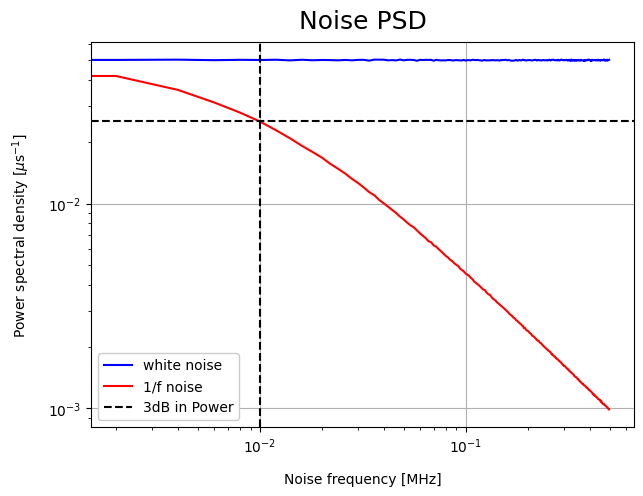

Checking definitions: 
Median PSD/ (Defined noise strength * t_max): 1.0021867754153615
Std dev of frequency shifts / Square-root of (noise strength * t_max): 1.003800746573408


In [26]:
# Set parameters
sample_rate = 1                      # per us
t_max = 500                          # in us
relative_PSD_strength = (1e-2)**2    # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = 1e-2                            # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 100000              # Number of Monte-Carlo trajectories
# Try white noise
t_list, trajectories_list, freq_list, white_noise_psds = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0, white=True)

white_noise_psd = np.mean(white_noise_psds, axis=0)

# Try 1/f noise
tlist, trajectories_list, freq_list, lowfreq_noise_psds = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0=1e-2, white=False)

lowfreq_noise_psd = np.mean(lowfreq_noise_psds, axis=0)

# Plot of power spectral density
plt.figure(figsize=(7, 5))
plt.title('Noise PSD', pad=10, size=18)
plt.loglog(freq_list, white_noise_psd, 'b', label="white noise")
plt.loglog(freq_list, lowfreq_noise_psd, 'r', label="1/f noise")
plt.axvline(x = f0, color='black', linestyle='dashed') 
plt.axhline(y = lowfreq_noise_psd[0]/2, color='black', linestyle='dashed', label="3dB in Power")
plt.ylabel(r"Power spectral density [$\mu$s$^{-1}$]", labelpad=12)
plt.xlabel("Noise frequency [MHz]", labelpad=12)
plt.legend(framealpha=1.0)
plt.grid()
plt.show()

print('Checking definitions: ')
print('Median PSD/ (Defined noise strength * t_max): '+str(np.median(white_noise_psd)/(relative_PSD_strength * t_max)))
print('Std dev of frequency shifts / Square-root of (noise strength * t_max): '+str( (np.std(trajectories_list, axis=0)[-1]) / (np.sqrt(relative_PSD_strength * t_max)) ))

In [33]:
tpi = 2.*np.pi

# Generate a bunch of trajectories for qubit dephasing
def monte_carlo_qubit(detuning=0.0, num_realizations=500, sample_rate=1, t_max=200, \
                      relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False):
    N = int(sample_rate*t_max) + 1                         # Total number of time points
    trajectories_list = np.zeros((num_realizations, N))    # List of trajectories
    H0 = tpi * detuning * qt.sigmaz()                      # Detuning in us^-1
    init_state = (qt.basis(2, 0) + qt.basis(2, 1)).unit()
    
    # Go over trajectories
    Xtraj_list, noise_psd = np.zeros((num_realizations, N)), np.zeros(N//2)
    for idx in range(num_realizations):
        t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
        trajectories_list[idx] = shifts
        noise_psd += psd
        H_tot = [H0, [tpi*qt.sigmaz(), shifts]]
        result = qt.sesolve(H_tot, init_state, t_list, e_ops=[qt.sigmax()])
        Xtraj_list[idx] = result.expect[0]
            
    noise_psd /= num_realizations
    
    return t_list, Xtraj_list, freq_list, noise_psd

In [34]:
# Set parameters
sample_rate = 1                       # per us
t_max = 200                           # in us
relative_PSD_strength = (1./100.)**2  # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = (1./100.)                        # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 1000               # Number of Monte-Carlo trajectories
detuning = 30                       # Ramsey detuning in units of us^-1

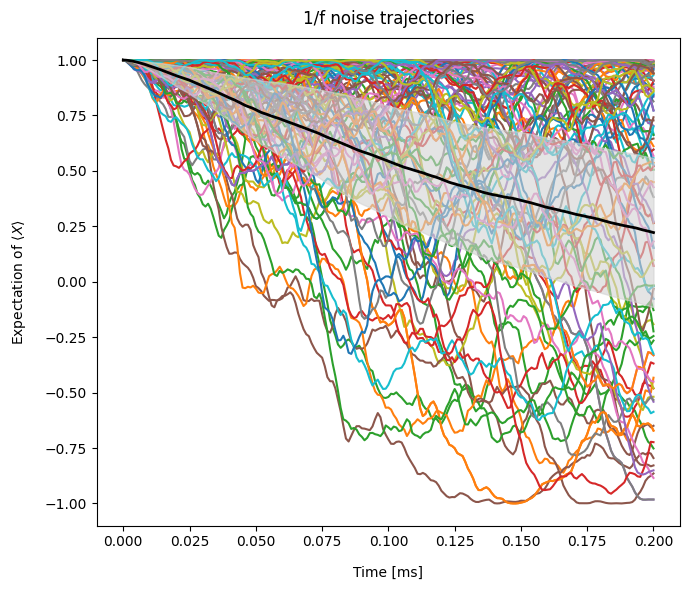

In [35]:
# Try 1/f noise
t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_qubit(detuning=detuning, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)

plt.figure(figsize=(7, 6))
for trajectory in Xtraj_list_lowfreq[np.random.choice(len(Xtraj_list_lowfreq), 100)]:
    plt.plot(t_list/1e3, trajectory)

plt.fill_between(t_list/1e3, mean_Xtraj_lowfreq-std_dev_trajectory/2., mean_Xtraj_lowfreq+std_dev_trajectory/2., color='lightgrey', alpha=0.6, zorder=3)
plt.plot(t_list/1e3, mean_Xtraj_lowfreq, color='black', linewidth=2.0, zorder=4)

plt.title('1/f noise trajectories', pad=10)
plt.xlabel(r"Time [ms]", labelpad=12)
plt.ylabel(r"Expectation of $\langle X \rangle$", labelpad=12)
plt.tight_layout()

In [106]:
class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, trunc):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-5
        self.trunc = trunc
        self.total_dim = trunc[-1]*trunc[-2]
        self.get_H()
        self.get_H_der()
        self.get_noise_operator()
        
        

    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)
    

    def sort_eigenpairs(self, eigenvalues, eigenvectors):
        n = eigenvectors.shape[0]
        sorted_indices = []

        for i in range(n):
            max_abs_vals = np.abs(eigenvectors[i, :])
            max_index = np.argmax(max_abs_vals)
            while max_index in sorted_indices:
                max_abs_vals[max_index] = -np.inf
                max_index = np.argmax(max_abs_vals)
            sorted_indices.append(max_index)

        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        return sorted_eigenvalues, sorted_eigenvectors

    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        self.omega_c = evals[1]
        self.omega_s = evals[self.cdim]
        self.chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]
        self.anh = evals[2*self.cdim] - 2*evals[self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control
        self.H = self.H[:self.total_dim, :self.total_dim]
        self.H_control = self.H_control[:self.total_dim, :self.total_dim]
        
        
    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        self.H_per = H
        self.H_control_per = H_control
        evals,evecs = np.linalg.eigh(H)
        evals,evecs = self.sort_eigenpairs(evals,evecs)
        evals = evals - evals[0]
        self.omega_s_per = evals[self.cdim]
        self.omega_c_per = evals[1]
        self.H_per = self.H_per[:self.total_dim, :self.total_dim]
        self.H_control_per = self.H_control_per[:self.total_dim, :self.total_dim]

    def get_noise_operator(self):
        H_per = self.H_per
        H = self.H
        self.noise = (H_per - H) / self.epsilon
        self.noise = self.noise[:self.total_dim, :self.total_dim]

    def get_sigmax(self):
        cavity_sigmax = np.zeros((self.cdim, self.cdim))
        cavity_sigmax[0,1] = 1
        cavity_sigmax[1,0] = 1
        sigmax = np.kron(np.eye(self.sdim), cavity_sigmax)
        sigmax = sigmax[:self.total_dim, :self.total_dim]
        return sigmax

        
        
    

In [113]:
# Generate a bunch of trajectories for qubit dephasing
def monte_carlo_qubit(detuning=0.0, num_realizations=1000, sample_rate=1, t_max=200, \
                      relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False):
    N = int(sample_rate*t_max) + 1                         # Total number of time points
    trajectories_list = np.zeros((num_realizations, N))    # List of trajectories
    
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    sc = Hamiltonian(phi_ex, Ej, Ec, [4,3])
    H0 = qt.Qobj(sc.H)
    init_state = (qt.basis(sc.total_dim, 0) + qt.basis(sc.total_dim, 1)).unit()
    sigmax = qt.Qobj(sc.get_sigmax())
    
    # Go over trajectories
    Xtraj_list, noise_psd = np.zeros((num_realizations, N)), np.zeros(N//2)
    for idx in range(num_realizations):
        t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
        trajectories_list[idx] = shifts
        noise_psd += psd
        noise_op = qt.Qobj(sc.noise)
        H_tot = [H0, [noise_op, shifts]]
        result = qt.sesolve(H_tot, init_state, t_list, e_ops=[sigmax])
        Xtraj_list[idx] = result.expect[0]
            
    noise_psd /= num_realizations
    
    return t_list, Xtraj_list, freq_list, noise_psd

In [114]:
# Try 1/f noise
t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_qubit(detuning=detuning, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)

# Create figure and plot individual trajectories
plt.figure(figsize=(7, 6))
num_trajectories = 100
random_indices = np.random.choice(len(Xtraj_list_lowfreq), num_trajectories)
for trajectory in Xtraj_list_lowfreq[random_indices]:
    plt.plot(t_list/1e3, trajectory, alpha=0.3, color='blue')

# Plot mean and standard deviation
plt.fill_between(t_list/1e3, 
                 mean_Xtraj_lowfreq - std_dev_trajectory,  # Show full standard deviation
                 mean_Xtraj_lowfreq + std_dev_trajectory,
                 color='gray', alpha=0.3, label='±1σ')
plt.plot(t_list/1e3, mean_Xtraj_lowfreq, 'r-', 
         linewidth=2.0, label='Mean trajectory')

plt.title('Quantum trajectories with 1/f noise', pad=10)
plt.xlabel(r"Time [ms]", labelpad=12)
plt.ylabel(r"$\langle \hat{X} \rangle$", labelpad=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Traceback (most recent call last):
  File "/Users/yunwei/Desktop/PycharmProjects/qutip/qutip/solver/integrator/scipy_integrator.py", line 63, in _mul_np_vec
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    def _mul_np_vec(self, t, vec):

KeyboardInterrupt


: 